In [586]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf

In [587]:
symbols =['AAPL', 'TSLA']
start = '2016-01-01'
end = '2024-02-29'

In [588]:
data = yf.download(symbols, start, end)['Adj Close']

[*********************100%%**********************]  2 of 2 completed


In [589]:
rets = np.log(data[symbols] / data[symbols].shift(1)).dropna()

In [590]:
rets

Ticker,AAPL,TSLA
Date,,
2016-01-05,-0.025379,0.000090
2016-01-06,-0.019764,-0.019844
2016-01-07,-0.043121,-0.015598
2016-01-08,0.005274,-0.021799
2016-01-11,0.016063,-0.015041
...,...,...
2024-02-16,-0.008466,-0.002498
2024-02-20,-0.004122,-0.031447
2024-02-21,0.004177,0.005199


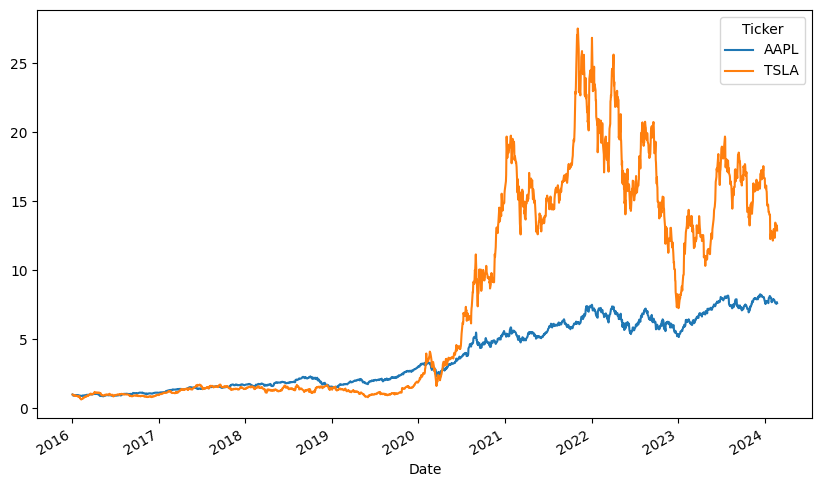

In [591]:
(data / data.iloc[0]).plot(figsize=(10, 6));

In [592]:
weights = len(rets.columns) * [1/ len(rets.columns)]

In [593]:
weights

[0.5, 0.5]

In [594]:
def port_return(rets, weights):
    return np.dot(rets.mean(), weights) * 252

In [595]:
port_return(rets, weights)

0.2822326611119429

In [596]:
def port_volatility(rets, weights):
    return np.dot(weights, np.dot(rets.cov() * 252, weights)) ** 0.5

In [597]:
port_volatility(rets, weights)

0.3781867714326457

In [598]:
def port_sharpe(rets, weights):
    return port_return(rets, weights) / port_volatility(rets, weights)

In [599]:
port_sharpe(rets, weights)

0.7462785121827245

In [600]:
w = np.random.random((1000, len(symbols)))
w = (w.T / w.sum(axis=1)).T

In [601]:
w

array([[0.64094019, 0.35905981],
       [0.19759967, 0.80240033],
       [0.70142154, 0.29857846],
       ...,
       [0.64650308, 0.35349692],
       [0.11629062, 0.88370938],
       [0.39132093, 0.60867907]])

In [602]:
w[:5]

array([[0.64094019, 0.35905981],
       [0.19759967, 0.80240033],
       [0.70142154, 0.29857846],
       [0.83926261, 0.16073739],
       [0.76181227, 0.23818773]])

In [603]:
pvr = [(port_volatility(rets[symbols], weights),
        port_return(rets[symbols], weights))
        for weights in w]
pvr = np.array(pvr)

In [604]:
psr = pvr[:, 1] / pvr[:, 0]

In [605]:
psr

array([0.81251165, 0.61116333, 0.83716967, 0.87262131, 0.85708128,
       0.69941705, 0.83145777, 0.77285739, 0.62373827, 0.82465602,
       0.8696323 , 0.57187386, 0.58433642, 0.87074533, 0.77724478,
       0.84614589, 0.84806521, 0.83194652, 0.78588252, 0.57480223,
       0.86396012, 0.80481596, 0.74833912, 0.73027827, 0.63015033,
       0.7475427 , 0.70306288, 0.75723904, 0.79449072, 0.87315385,
       0.55970767, 0.56289891, 0.70837487, 0.77370608, 0.76024358,
       0.56836187, 0.62729514, 0.80571851, 0.67344687, 0.65419056,
       0.75207478, 0.68800838, 0.71162927, 0.62040898, 0.64599344,
       0.69285151, 0.82865735, 0.86989796, 0.87143756, 0.74611007,
       0.6846187 , 0.76492715, 0.6909167 , 0.77917604, 0.67090907,
       0.875031  , 0.76590868, 0.69334962, 0.57585469, 0.64445654,
       0.87360626, 0.63341059, 0.81869715, 0.85529828, 0.86060937,
       0.75175478, 0.74369063, 0.68809755, 0.75920447, 0.56541129,
       0.64638864, 0.83347957, 0.60145914, 0.72816546, 0.66609

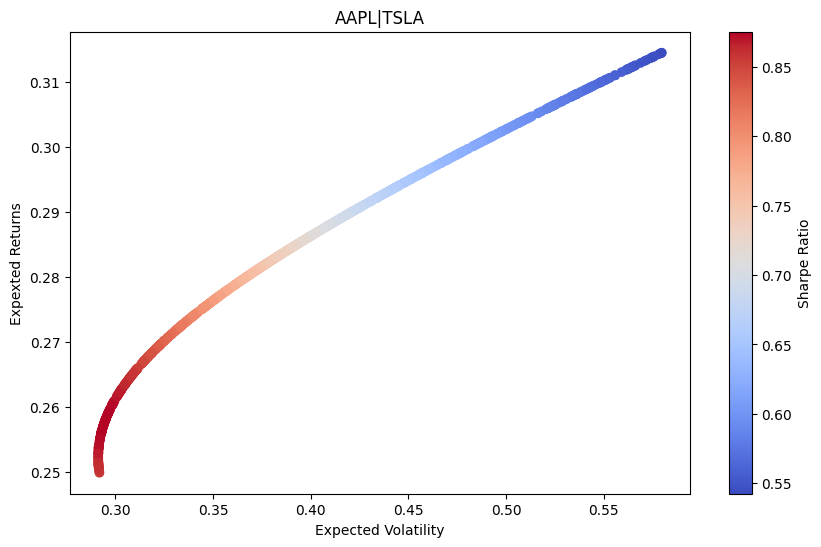

In [606]:
plt.figure(figsize=(10, 6))
fig = plt.scatter(pvr[:, 0], pvr[:, 1],
                  c=psr, cmap='coolwarm')
cb = plt.colorbar(fig)
cb.set_label('Sharpe Ratio')
plt.xlabel('Expected Volatility')
plt.ylabel('Expexted Returns')
plt.title('|'.join(symbols));

In [607]:
bns = len(symbols) * [(0, 1),]

In [608]:
bns

[(0, 1), (0, 1)]

In [609]:
cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}

In [610]:
opt_weights = {}
for year in range(2016, 2024):
    rets_ = rets[symbols].loc[f'{year}-01-01':f'{year}-12-31']
    ow = minimize(lambda weights: -port_sharpe(rets, weights),
                  len(symbols) * [1 / len(symbols)],
                  bounds= bns,
                  constraints=cons)['x']
    opt_weights[year] = ow

In [611]:
opt_weights

{2016: array([0.8831892, 0.1168108]),
 2017: array([0.8831892, 0.1168108]),
 2018: array([0.8831892, 0.1168108]),
 2019: array([0.8831892, 0.1168108]),
 2020: array([0.8831892, 0.1168108]),
 2021: array([0.8831892, 0.1168108]),
 2022: array([0.8831892, 0.1168108]),
 2023: array([0.8831892, 0.1168108])}

In [612]:
res = pd.DataFrame()
for year in range(2016, 2024):
    rets_ = rets[symbols].loc[f'{year}-01-01':f'{year}-12-31']
    epv = port_volatility(rets_, opt_weights[year])
    epr = port_return(rets_, opt_weights[year])
    esr = epr / epv
    rets_ = rets[symbols].loc[f'{year + 1}-01-01': f'{year + 1}-12-31']
    rpv = port_volatility(rets_, opt_weights[year])
    rpr = port_return(rets_, opt_weights[year])
    rsr = rpr / rpv
    res  = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,
                                    'rpv': rpv, 'rpr': rpr, 'rsr': rsr},
                                   index=[year + 1]))

<ipython-input-612-0f3290066266>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res  = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,
<ipython-input-612-0f3290066266>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res  = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,
<ipython-input-612-0f3290066266>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res  = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,
<ipython-input-612-0f3290066266>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res  = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,
<ipython-input-612-0f3290066266>:11: Fut

In [613]:
res

,epv,epr,esr,rpv,rpr,rsr
2017,0.222662,0.098310,0.441522,0.170597,0.394546,2.312739
2018,0.170597,0.394546,2.312739,0.283055,-0.041318,-0.145972
2019,0.283055,-0.041318,-0.145972,0.257172,0.588739,2.289281
2020,0.257172,0.588739,2.289281,0.472495,0.776370,1.643127
2021,0.472495,0.776370,1.643127,0.256474,0.309917,1.208374
2022,0.256474,0.309917,1.208374,0.369561,-0.395074,-1.069035
2023,0.369561,-0.395074,-1.069035,0.216046,0.437684,2.025889
2024,0.216046,0.437684,2.025889,0.187747,-0.518773,-2.763146


In [614]:
res.mean()

epv    0.281008
epr    0.271147
esr    1.088241
rpv    0.276643
rpr    0.194011
rsr    0.687657
dtype: float64

In [615]:
res[['epv', 'rpv']].corr()

,epv,rpv
epv,1.000000,-0.072946
rpv,-0.072946,1.000000


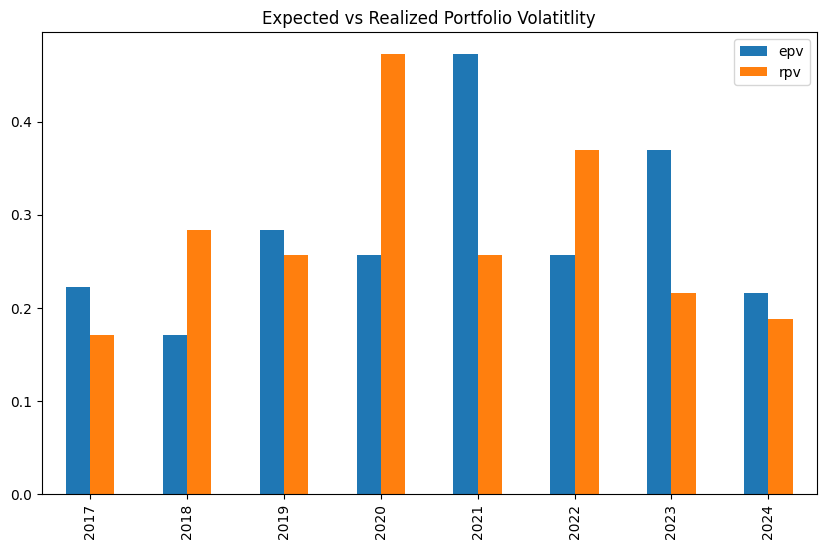

In [616]:
res[['epv', 'rpv']].plot(kind='bar', figsize=(10, 6),
                         title = 'Expected vs Realized Portfolio Volatitlity');

In [617]:
res[['epr', 'rpr']].corr()

,epr,rpr
epr,1.000000,-0.203658
rpr,-0.203658,1.000000


<Axes: title={'center': 'Expected VS Realized Portfolio Volatitltiy'}>

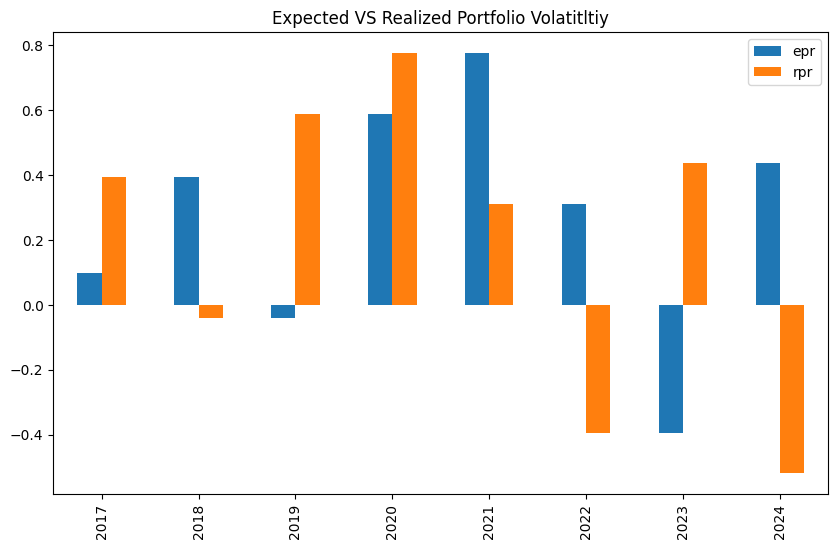

In [618]:
res[['epr', 'rpr']].plot(kind='bar', figsize=(10, 6),
                         title ='Expected VS Realized Portfolio Volatitltiy')

In [619]:
market = '^GSPC'
start_date  ='2016-01-01'
end_date = '2024-02-29'

In [620]:
market_data = yf.download(market, start_date, end_date)['Adj Close']

[*********************100%%**********************]  1 of 1 completed


In [621]:
market_data

Date
2016-01-04    2012.660034
2016-01-05    2016.709961
2016-01-06    1990.260010
2016-01-07    1943.089966
2016-01-08    1922.030029
                 ...     
2024-02-16    5005.569824
2024-02-20    4975.509766
2024-02-21    4981.799805
2024-02-22    5087.029785
2024-02-23    5088.799805
Name: Adj Close, Length: 2049, dtype: float64

In [622]:
data_A = data['AAPL']

In [623]:
data_A

Date
2016-01-04     23.946920
2016-01-05     23.346828
2016-01-06     22.889940
2016-01-07     21.923876
2016-01-08     22.039803
                 ...    
2024-02-16    182.309998
2024-02-20    181.559998
2024-02-21    182.320007
2024-02-22    184.369995
2024-02-23    182.520004
Name: AAPL, Length: 2049, dtype: float64

In [624]:
data_1 = pd.concat([data_A, market_data], axis=1)

In [625]:
data_1.columns = ['Asset_APPL', 'Market']

In [626]:
data_1

,Asset_APPL,Market
Date,,
2016-01-04,23.946920,2012.660034
2016-01-05,23.346828,2016.709961
2016-01-06,22.889940,1990.260010
2016-01-07,21.923876,1943.089966
2016-01-08,22.039803,1922.030029
...,...,...
2024-02-16,182.309998,5005.569824
2024-02-20,181.559998,4975.509766
2024-02-21,182.320007,4981.799805


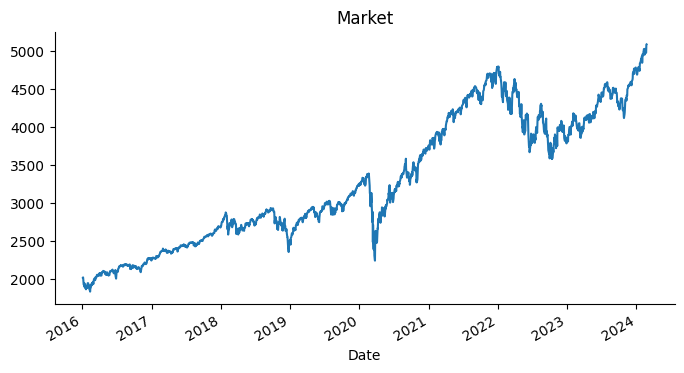

In [627]:
# @title Market

from matplotlib import pyplot as plt
data_1['Market'].plot(kind='line', figsize=(8, 4), title='Market')
plt.gca().spines[['top', 'right']].set_visible(False)

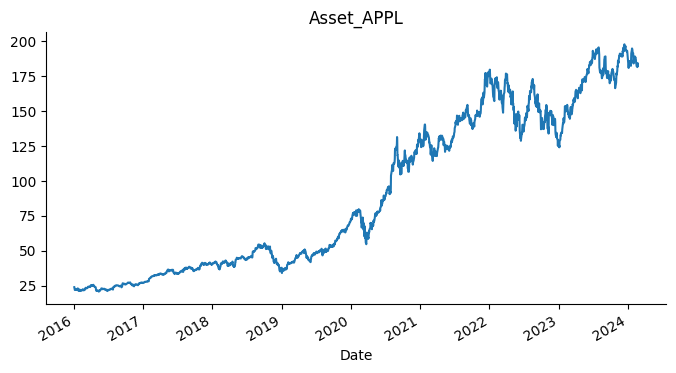

In [628]:
# @title Asset_APPL

from matplotlib import pyplot as plt
data_1['Asset_APPL'].plot(kind='line', figsize=(8, 4), title='Asset_APPL')
plt.gca().spines[['top', 'right']].set_visible(False)

In [629]:
returns_1 = np.log(data_1/ data_1.shift(1)).dropna()

In [630]:
returns_1

,Asset_APPL,Market
Date,,
2016-01-05,-0.025379,0.002010
2016-01-06,-0.019764,-0.013202
2016-01-07,-0.043121,-0.023986
2016-01-08,0.005274,-0.010898
2016-01-11,0.016063,0.000853
...,...,...
2024-02-16,-0.008466,-0.004815
2024-02-20,-0.004122,-0.006023
2024-02-21,0.004177,0.001263


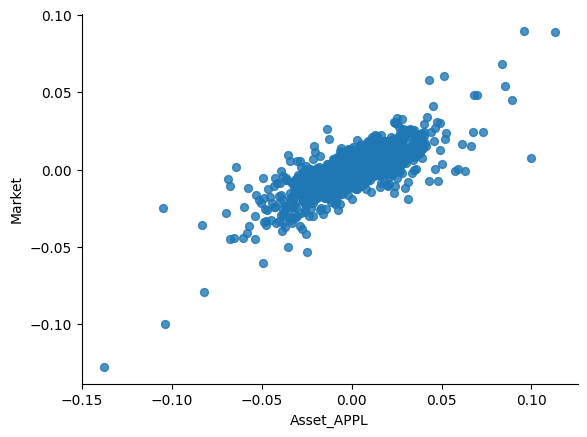

In [631]:
# @title Asset_APPL vs Market

from matplotlib import pyplot as plt
returns_1.plot(kind='scatter', x='Asset_APPL', y='Market', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

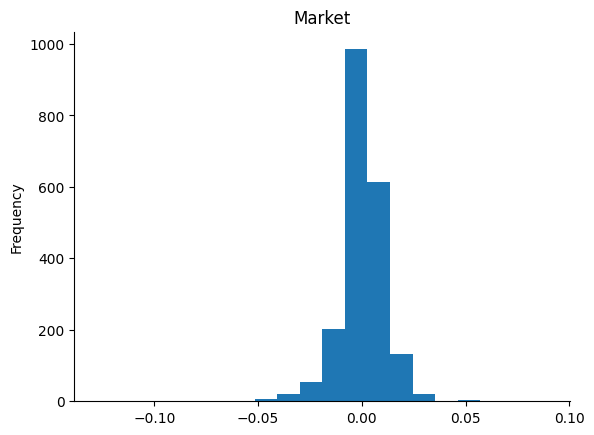

In [632]:
# @title Market

from matplotlib import pyplot as plt
returns_1['Market'].plot(kind='hist', bins=20, title='Market')
plt.gca().spines[['top', 'right',]].set_visible(False)

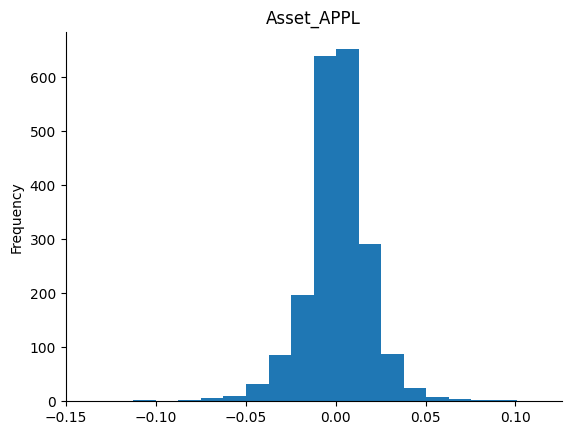

In [633]:
# @title Asset_APPL

from matplotlib import pyplot as plt
returns_1['Asset_APPL'].plot(kind='hist', bins=20, title='Asset_APPL')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [634]:
from scipy.stats import stats

In [635]:
slope, intercept, r_value, p_value, std_err = stats.linregress(returns_1['Asset_APPL'], returns_1['Market'])
beta= slope

<ipython-input-635-3dced111df95>:1: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, r_value, p_value, std_err = stats.linregress(returns_1['Asset_APPL'], returns_1['Market'])


In [636]:
beta

0.4903374277055118

In [637]:
data_T = data['TSLA']


In [638]:
data_2 = pd.concat([data_T, market_data], axis=1)

In [639]:
data_2

,TSLA,Adj Close
Date,,
2016-01-04,14.894000,2012.660034
2016-01-05,14.895333,2016.709961
2016-01-06,14.602667,1990.260010
2016-01-07,14.376667,1943.089966
2016-01-08,14.066667,1922.030029
...,...,...
2024-02-16,199.949997,5005.569824
2024-02-20,193.759995,4975.509766
2024-02-21,194.770004,4981.799805


In [640]:
data_2.columns= ['Asset_TSLA', 'Market_2']

In [642]:
returns_2 = np.log(data_2 / data_2.shift(1)).dropna()

In [643]:
returns_2

,Asset_TSLA,Market_2
Date,,
2016-01-05,0.000090,0.002010
2016-01-06,-0.019844,-0.013202
2016-01-07,-0.015598,-0.023986
2016-01-08,-0.021799,-0.010898
2016-01-11,-0.015041,0.000853
...,...,...
2024-02-16,-0.002498,-0.004815
2024-02-20,-0.031447,-0.006023
2024-02-21,0.005199,0.001263


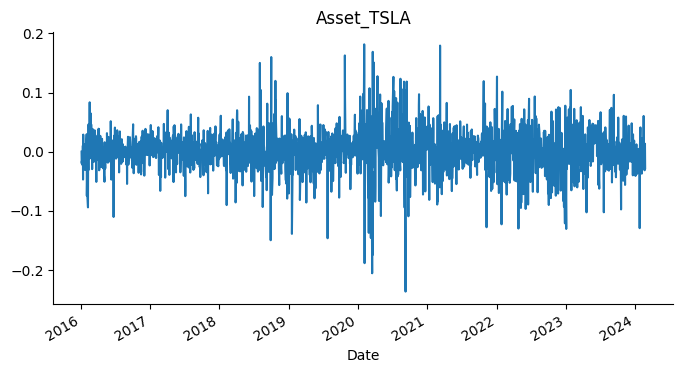

In [644]:
# @title Asset_TSLA

from matplotlib import pyplot as plt
returns_2['Asset_TSLA'].plot(kind='line', figsize=(8, 4), title='Asset_TSLA')
plt.gca().spines[['top', 'right']].set_visible(False)

In [645]:
slope, intercept, r_value, p_value, std_err = stats.linregress(returns_2['Market_2'], returns_2['Asset_TSLA'])
beta = slope

<ipython-input-645-946886829cd4>:1: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, r_value, p_value, std_err = stats.linregress(returns_2['Market_2'], returns_2['Asset_TSLA'])


In [646]:
beta

1.478464413217018

# **AAPL Beta WITH** **ARIMA**

In [648]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

In [649]:
data_A_returns = np.log(data_A / data_A.shift(1)).dropna()

In [650]:
data_A_returns

Date
2016-01-05   -0.025379
2016-01-06   -0.019764
2016-01-07   -0.043121
2016-01-08    0.005274
2016-01-11    0.016063
                ...   
2024-02-16   -0.008466
2024-02-20   -0.004122
2024-02-21    0.004177
2024-02-22    0.011181
2024-02-23   -0.010085
Name: AAPL, Length: 2048, dtype: float64

In [651]:
market_returns = np.log(market_data / market_data.shift(1)).dropna()

In [652]:
market_returns

Date
2016-01-05    0.002010
2016-01-06   -0.013202
2016-01-07   -0.023986
2016-01-08   -0.010898
2016-01-11    0.000853
                ...   
2024-02-16   -0.004815
2024-02-20   -0.006023
2024-02-21    0.001263
2024-02-22    0.020903
2024-02-23    0.000348
Name: Adj Close, Length: 2048, dtype: float64

In [653]:
model = ARIMA(data_A_returns, order=(1, 1, 1))
fitted_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [655]:
predicted_Asset_APPL = fitted_model.predict(start=len(data_A_returns), end=len(data_A_returns) + 5)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [656]:
predicted_Asset_APPL

2048    0.001702
2049    0.000782
2050    0.000854
2051    0.000848
2052    0.000849
2053    0.000849
Name: predicted_mean, dtype: float64

In [658]:
X = market_returns.values.reshape(-1, 1)
y = data_A_returns.values.reshape(-1, 1)

In [659]:
regression_model = LinearRegression()
regression_model.fit(X,y)
beta = regression_model.coef_[0][0]

In [660]:
print('Estimated Beta Using ARIMA', beta)

Estimated Beta Using ARIMA 1.206686159765532


# **TESLA ARIMA With Beta**

In [661]:
data_returns_T  = np.log(data_T / data_T.shift(1)).dropna()

In [662]:
data_returns_T

Date
2016-01-05    0.000090
2016-01-06   -0.019844
2016-01-07   -0.015598
2016-01-08   -0.021799
2016-01-11   -0.015041
                ...   
2024-02-16   -0.002498
2024-02-20   -0.031447
2024-02-21    0.005199
2024-02-22    0.013463
2024-02-23   -0.027944
Name: TSLA, Length: 2048, dtype: float64

In [663]:
model = ARIMA(data_returns_T, order=(1, 1, 1))
fitted_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [664]:
predicted_Asset_TSLA = fitted_model.predict(start=len(data_returns_T), end=len(data_returns_T) + 5)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [665]:
predicted_Asset_TSLA

2048    0.000062
2049   -0.000211
2050   -0.000209
2051   -0.000209
2052   -0.000209
2053   -0.000209
Name: predicted_mean, dtype: float64

In [666]:
X_ = market_returns.values.reshape(-1, 1)
y_ = data_returns_T.values.reshape(-1, 1)


In [667]:
regression_model = LinearRegression()
regression_model.fit(X_, y_)
beta = regression_model.coef_[0][0]

In [668]:
print("Estimated Beta Using ARIMA:", beta)

Estimated Beta Using ARIMA: 1.4784644132170193
